<a href="https://colab.research.google.com/github/prasanna-venkatesh-m/RNN-Basics/blob/main/Multioutput_RNN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
data = pd.read_excel('/content/OD.xlsx')

In [3]:
columns = ['TotalCountOfAccounts', 'TotalPrincipalOutstanding',
       'TotalInterestOutstanding', 'TotalPrincipalOverdue',
       'TotalInterestOverdue']
values = data[columns].values

In [4]:
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

In [5]:
window = 15
X, y = create_sequences(values, window)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (494, 15, 5)
y shape: (494, 5)


In [6]:
def scale_features_targets(X, y):
    n_features = X.shape[2]
    n_targets = y.shape[1]

    X = X.astype(float)
    y = y.astype(float)

    feature_scalers = {}
    X_scaled = np.zeros_like(X)

    for i in range(n_features):
        feature_scalers[i] = MinMaxScaler(feature_range=(-1, 1))

        feature_data = X[:, :, i].reshape(-1, 1)
        X_scaled[:, :, i] = feature_scalers[i].fit_transform(feature_data).reshape(X[:, :, i].shape)

    target_scalers = {}
    y_scaled = np.zeros_like(y)
    for i in range(n_targets):
        target_scalers[i] = MinMaxScaler(feature_range=(-1, 1))
        y_scaled[:, i] = target_scalers[i].fit_transform(y[:, i].reshape(-1, 1)).flatten()

    return X_scaled, y_scaled, feature_scalers, target_scalers


In [7]:
def inverse_transform_targets(scaler,data):
    actual_data = np.zeros_like(data, dtype=float)

    for i in range(data.shape[1]):
        actual_data[:, i] = scaler[i].inverse_transform(data[:, i].reshape(-1, 1)).flatten()

    return actual_data

In [8]:
x_scaled, y_scaled, feature_scalers, target_scalers = scale_features_targets(X, y)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, shuffle=False)

In [31]:
def train_model(x_train, y_train, x_test, y_test, epochs=50):
  lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True ,input_shape=(x_train.shape[1],x_train.shape[2])),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5)
  ])

  lstm_model.compile(optimizer= tf.keras.optimizers.Adam(),
                    loss = tf.keras.losses.MeanSquaredError(),
                    metrics = [tf.keras.metrics.MeanAbsoluteError()])

  lstm_model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

  return lstm_model

In [32]:
def predict_model(model, x_test, y_test):
    lstm_y_pred_scaled = model.predict(x_test)
    lstm_y_pred = inverse_transform_targets(target_scalers,lstm_y_pred_scaled)
    y_test_actual = inverse_transform_targets(target_scalers, y_test)
    print(mean_squared_error(lstm_y_pred, y_test_actual))
    print(mean_absolute_error(lstm_y_pred, y_test_actual))
    return lstm_y_pred, lstm_y_pred_scaled, y_test_actual

In [33]:
model = train_model(x_train, y_train, x_test, y_test, epochs=100)
y_pred, y_hat, y_actual = predict_model(model, x_test, y_test)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1818 - mean_absolute_error: 0.3112 - val_loss: 0.1127 - val_mean_absolute_error: 0.2984
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0173 - mean_absolute_error: 0.1000 - val_loss: 0.0366 - val_mean_absolute_error: 0.1718
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0072 - mean_absolute_error: 0.0648 - val_loss: 0.0217 - val_mean_absolute_error: 0.1136
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0065 - mean_absolute_error: 0.0602 - val_loss: 0.0323 - val_mean_absolute_error: 0.1324
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0060 - mean_absolute_error: 0.0590 - val_loss: 0.0259 - val_mean_absolute_error: 0.1214
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0057 - mean_absolute_error: 0.0557 - val_loss: 0.0310 - val_mean_absolute_error: 0.1283
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0060 - mean_absolute_error: 0.0569 - val_loss: 0.0

MAE : 2974.679450757577 Percentage : 5.0


/tmp/ipython-input-4089641592.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'MAE : {mae} Percentage : {np.round(np.multiply(mae / data.mean()[i+1], 100))}')


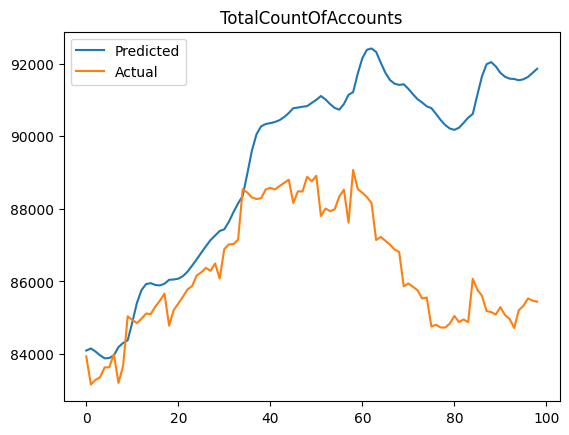

MAE : 54817251.898989916 Percentage : 5.0


/tmp/ipython-input-4089641592.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'MAE : {mae} Percentage : {np.round(np.multiply(mae / data.mean()[i+1], 100))}')


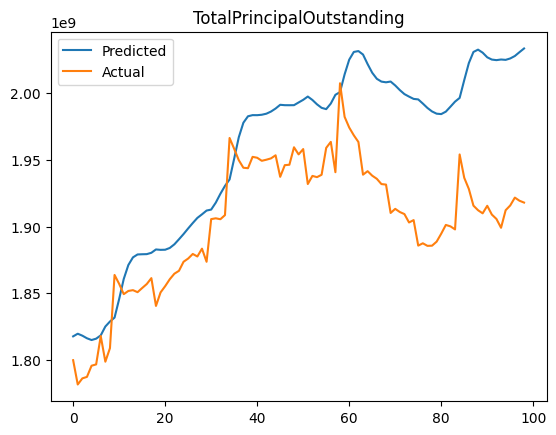

/tmp/ipython-input-4089641592.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'MAE : {mae} Percentage : {np.round(np.multiply(mae / data.mean()[i+1], 100))}')


MAE : 4658296.020202019 Percentage : 3.0


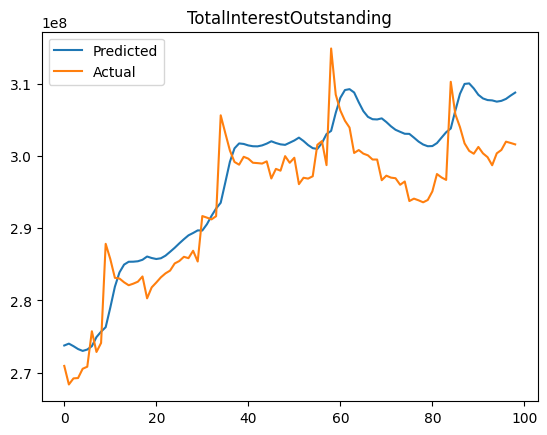

/tmp/ipython-input-4089641592.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'MAE : {mae} Percentage : {np.round(np.multiply(mae / data.mean()[i+1], 100))}')


MAE : 37569722.797979794 Percentage : 6.0


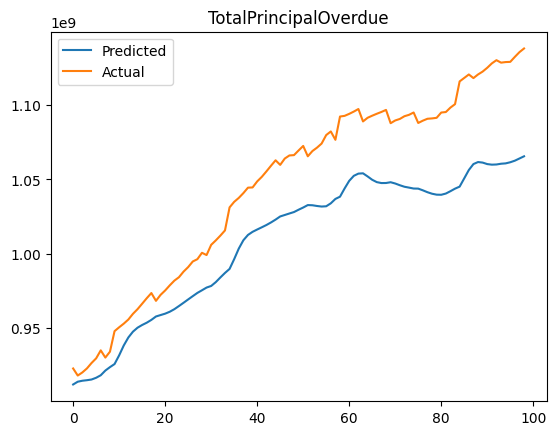

/tmp/ipython-input-4089641592.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'MAE : {mae} Percentage : {np.round(np.multiply(mae / data.mean()[i+1], 100))}')


MAE : 13032957.383838383 Percentage : 16.0


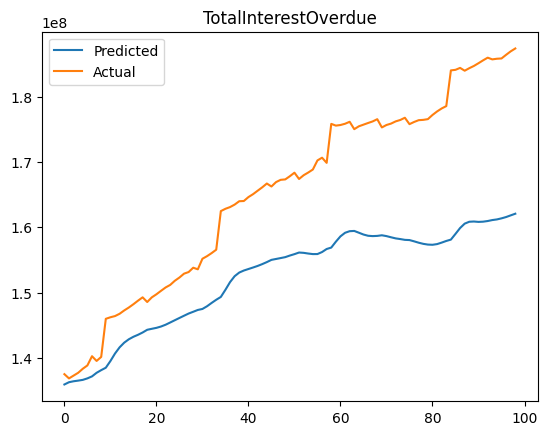

In [34]:
import warnings
warnings.filterwarnings
for i in range(y.shape[1]):
  mae= mean_absolute_error(y_pred[:,i],y_actual[:,i])
  plt.plot(y_pred[:,i], label='Predicted')
  plt.plot(y_actual[:,i], label='Actual')
  print(f'MAE : {mae} Percentage : {np.round(np.multiply(mae / data.mean()[i+1], 100))}')
  plt.title(columns[i])
  plt.legend()
  plt.show()